In [1]:
import httpx
import cv2
from urllib.parse import urlparse
import base64

import numpy as np
import matplotlib.pyplot as plt


data = {
    "images": {},
    "threshold": 0.6,
    "extract_ga": True,
    "extract_embedding": True,
    "return_face_data": False,
    "return_landmarks": True,
    "embed_only": False,
    "limit_faces": 0,
    "detect_masks": True,
    "msgpack": False,
}

In [2]:
def read_image(path_or_url):
    """
    Reads an image from a file or a URL using OpenCV.

    Args:
        path_or_url (str): The file path or URL of the image.

    Returns:
        numpy.ndarray: The loaded image as a NumPy array.
    """
    try:
        # Check if input is a URL
        parsed = urlparse(path_or_url)
        if parsed.scheme in ("http", "https"):
            # Read image from URL
            with httpx.stream("GET", path_or_url, timeout=10) as response:
                if response.status_code == 200:
                    # Read the response content as bytes
                    image_array = np.asarray(bytearray(response.read()), dtype="uint8")
                    # Decode the image using OpenCV
                    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
                    if image is None:
                        raise ValueError("Failed to decode image from URL.")
                    return image
                else:
                    raise ValueError(
                        f"Failed to fetch image from URL: {response.status_code}"
                    )
        else:
            # Read image from local file
            image = cv2.imread(path_or_url, cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError("Failed to read image from the file path.")
            return image
    except Exception as e:
        print(f"Error: {e}")
        return None


def image_to_base64(image):
    """
    Encodes an image to a Base64 string.

    Args:
        image_path (str): The file path of the image.

    Returns:
        str: The Base64-encoded string of the image.
    """
    try:
        # Read the image file
        # Encode the image as a binary buffer
        _, buffer = cv2.imencode(".jpg", image)

        # Convert the binary buffer to a Base64 string
        base64_string = base64.b64encode(buffer).decode("utf-8")

        return base64_string
    except Exception as e:
        print(f"Error: {e}")
        return None


def drawing(
    image,
    bbox,
    landmarks,
    caption=None,
    bbox_color=(0, 255, 0),
    landmark_color=(0, 0, 255),
    text_color=(0, 0, 0),
    thickness=2,
    radius=3,
    font_scale=0.5,
):
    """
    Draws a bounding box, landmarks, and an optional caption on an image.

    Args:
        image (numpy.ndarray): The image on which to draw.
        bbox (tuple): Bounding box as (x, y, w, h).
        landmarks (list of tuples): List of (x, y) coordinates for the landmarks.
        caption (str): Optional text to display above the bounding box.
        bbox_color (tuple): Color of the bounding box in BGR (default: green).
        landmark_color (tuple): Color of the landmarks in BGR (default: red).
        text_color (tuple): Color of the caption text in BGR (default: white).
        thickness (int): Thickness of the bounding box lines.
        radius (int): Radius of the landmarks.
        font_scale (float): Font scale for the caption text.

    Returns:
        numpy.ndarray: The image with the bounding box, landmarks, and caption drawn.
    """
    # Draw the bounding box
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), bbox_color, thickness)

    # Draw the landmarks
    for landmark in landmarks:
        lx, ly = landmark
        cv2.circle(image, (int(lx), int(ly)), radius, landmark_color, -1)

    # Draw the caption above the bounding box
    if caption:
        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(
            caption, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1
        )
        # Background rectangle for the caption
        cv2.rectangle(
            image, (x, y - text_height - 10), (x + text_width, y), bbox_color, -1
        )
        # Add text on top of the rectangle
        cv2.putText(
            image,
            caption,
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            1,
            lineType=cv2.LINE_AA,
        )

    return image


def xyxy_to_xywh(xyxy):
    """
    Converts a bounding box from (x_min, y_min, x_max, y_max) format to (x, y, width, height) format.

    Args:
        xyxy (tuple): A tuple (x_min, y_min, x_max, y_max).

    Returns:
        tuple: A tuple (x, y, width, height).
    """
    x_min, y_min, x_max, y_max = xyxy
    width = x_max - x_min
    height = y_max - y_min
    return (x_min, y_min, width, height)

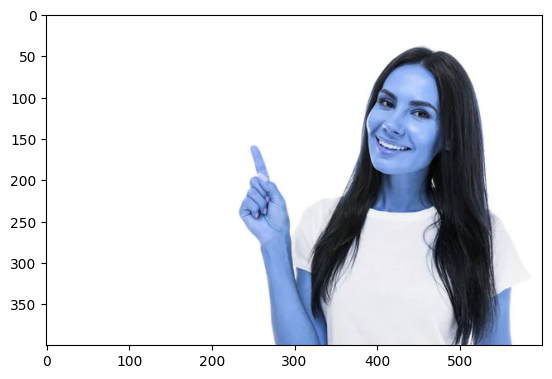

In [3]:
image_path = "./examples/test_01.jpg"
image = read_image(image_path)
plt.imshow(image)

In [4]:
url = "http://0.0.0.0:18080/extract"
data["images"] = {"data": [image_to_base64(image)]}
isf_resp = httpx.post(url=url, json=data)
rsp = isf_resp.json()
type(rsp)

dict

In [5]:
isf_data = rsp.get("data")
face_data = isf_data[0].get("faces")
face_data

[{'bbox': [387, 61, 481, 193],
  'landmarks': [[409, 106], [451, 122], [417, 141], [396, 146], [439, 161]],
  'prob': 0.8393247127532959,
  'num_det': 0,
  'scale': 1.0666666666666667,
  'norm': 22.410886764526367,
  'vec': [0.06383722275495529,
   -0.03834827244281769,
   -0.0029553421773016453,
   -0.07507271319627762,
   0.033879492431879044,
   0.022074351087212563,
   -0.07954444736242294,
   0.05062513053417206,
   -0.03964865580201149,
   -0.017774229869246483,
   0.009225528687238693,
   -0.0024683335795998573,
   0.043572597205638885,
   0.01241761352866888,
   0.040333446115255356,
   0.027050860226154327,
   -0.035155367106199265,
   -0.012755155563354492,
   -0.07093080133199692,
   -0.07475661486387253,
   0.037692002952098846,
   -0.014897787943482399,
   0.04683837667107582,
   0.008581092581152916,
   -0.06580931693315506,
   -0.1346740424633026,
   0.03067312389612198,
   0.007039476651698351,
   0.015102127566933632,
   0.053509779274463654,
   -0.037696465849876404,


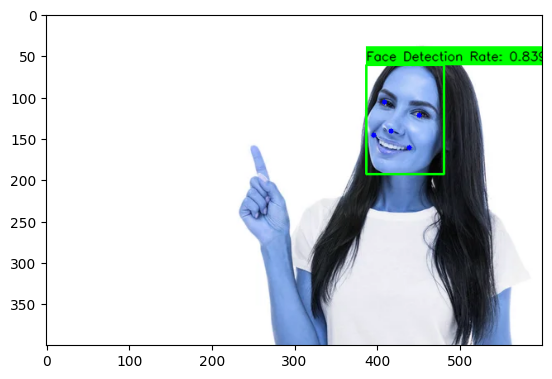

In [6]:
bbox = face_data[0].get("bbox")
landmarks = face_data[0].get("landmarks")
caption = f"Face Detection Rate: {face_data[0].get('prob')}\nGender: {'Male' if face_data[0].get('gender') == 1 else 'Female'}\nApprx. Age: {face_data[0].get('age')}\nMask: {face_data[0].get('mask')}"

from copy import deepcopy

img = deepcopy(image)
decor_img = drawing(img, xyxy_to_xywh(bbox), landmarks, caption)
plt.imshow(decor_img)

In [7]:
def crop_image_by_bbox(image, bbox):
    """
    Crops an image using a bounding box in (x_min, y_min, x_max, y_max) format.

    Args:
        image (numpy.ndarray): The input image as a NumPy array.
        bbox (tuple): The bounding box as (x_min, y_min, x_max, y_max).

    Returns:
        numpy.ndarray: The cropped image.
    """
    x_min, y_min, x_max, y_max = bbox
    # Ensure the coordinates are within the image boundaries
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(image.shape[1], x_max)
    y_max = min(image.shape[0], y_max)
    # Crop the image
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

In [10]:
bbox

[387, 61, 481, 193]

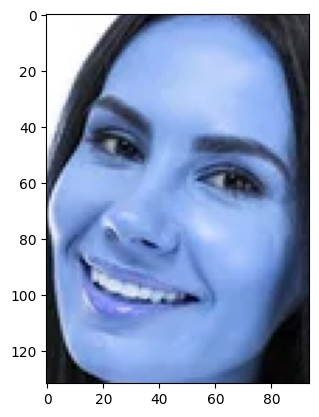

In [8]:
plt.imshow(crop_image_by_bbox(image, bbox))